In [10]:
from IPython.display import Image
#Image(filename='filepath/filename.jpg')

<h1 style="text-align: center;"> Google Mobility Data </p>

## Table of contents
1. [Problem Domain](#Problem-Domain)
2. [Required Libraries](#Required-Libraries)
3. [Google Mobility Data](#Google-Mobililty-Data)
4. [Data Exploration](#Data-Exploration)
5. [Visualizations](#Visualizations)
6. [Resampling](#Resampling)<br>
7. [Decomposition](#Decomposition)
8. [Time Series Stationarity](#Time-Series-Stationarity)
9. [Making Time Series Stationary](#Making-Time-Series-Stationary)
10. [Autocorrelations and Partial Autocorrelations](#Autocorrelations-and-Partial-Autocorrelations)
11. [ARIMA Modelling](#ARIMA-Modelling)
12. [Conclusion](#Conclusion)

## Problem Domain

[[ go back to the top ]](#Table-of-contents)

In this notebook, time-series processing methods are applied for forecasting stock prices as part of the requirements of the RMDS 2021 Data Science Competition. Here, the *Google COVID-19 Community Mobility Reports* are leveraged to generate insights with time series modeling. We have just over one year of daily mobility data, measured as the percent change from established baseline values.

Google has provided access to this anonymized data in support of public health efforts to combat COVID-19. There is no historical connection of this data with oil stock performance and thus there are no currently established metrics driving performance decisions.

Identifying trends and impact of different set points and operation upsets will help operators to make better decisions on how to operate the well. Not every operator and data scientist has access to the reservoir simulation software and they are highly technical and expensive to work with, whereas historical data is available to everyone. The purpose of this analysis is not to simulate the production of the gas well since there are many factors that need to be taken into consideration. We intend to give data scientists and operators a tool to quickly identify patterns and generate insights and use it as a lense in their day to day decision making.

<br>**Note:** The data set we're working with is 

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python libraries such as:

In [11]:
# Load required packages 
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Time-Series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy import signal
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

<a id='Google-Mobility-Data'></a>

## Google Mobility Data

[[ go back to the top ]](#Table-of-contents)

This dataset contains just over a year's worth of daily-frequency data from six sub-categories ("Indicators") in the United States. A total of 382 records, aggregated across county and state levels, were collected from 2020-02-15 to 2021-03-02 (YYYY-MM-DD). Each mobility indicator is measured as percent change from baseline.

From the official documentation website ([source](https://www.google.com/covid19/mobility/data_documentation.html?hl=en)):

Baseline

*    The median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.

**Place Categories**

|Indicator|Data Type|Dataset|Region-Frequency|Description|
|---|---|---|---|---|
|**Grocery & Pharmacy**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.|
|**Parks**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.|
|**Transit Stations**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like public transport hubs such as subway, bus, and train stations.|
|**Retail & Recreation**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.|
|**Residential**|*float*|Google Mobility|U.S. Daily|Mobility trends for places of residence.|
|**Workplaces**|*float*|Google Mobility|U.S. Daily|Mobility trends for places of work.|

#### Load Data

In [12]:
# The file path may change depending on the final Team Repo organization
df = pd.read_csv('../../data/Transportation/google/baseline_pct_change.csv',
                 index_col = 'date',
                 parse_dates = ['date'],
                 infer_datetime_format = True)
df.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382 entries, 2020-02-15 to 2021-03-02
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   workplaces             382 non-null    float64
 1   retail_and_recreation  382 non-null    float64
 2   grocery_and_pharmacy   382 non-null    float64
 3   residential            382 non-null    float64
 4   transit_stations       382 non-null    float64
 5   parks                  382 non-null    float64
dtypes: float64(6)
memory usage: 20.9 KB


#### Add Calculated Columns

Some important metrics can be calculated and included in the modeling.

In [13]:
#df['new_column'] = df.column1 - df.column2
#df.head()

## Data Exploration

[[ go back to the top ]](#Table-of-contents)

In [14]:
df.describe()

,workplaces,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,-22.582403,-11.547427,-0.750976,7.838999,-14.317257,24.251034
std,12.494321,12.966475,9.261214,4.901552,11.531974,32.598749
min,-81.157165,-85.804245,-63.582004,-2.083620,-51.829450,-33.880145
25%,-28.958435,-18.120157,-5.323603,5.010812,-21.973824,-2.112958
50%,-22.300172,-9.899883,-1.259989,7.433015,-13.917977,18.261794
75%,-14.448762,-3.747269,4.685063,9.709659,-5.995699,51.333475
max,3.791012,19.652863,32.806560,26.579684,14.546265,95.621185


> *Observations*
>
> Notice: We do not have to deal with missing values. However, all mobility indicators seems to have tailed off extreme values. 

## Visualizations

[[ go back to the top ]](#Table-of-contents)

In [15]:
plt.rcParams["figure.figsize"] = (20,20)
plt.style.use('seaborn')

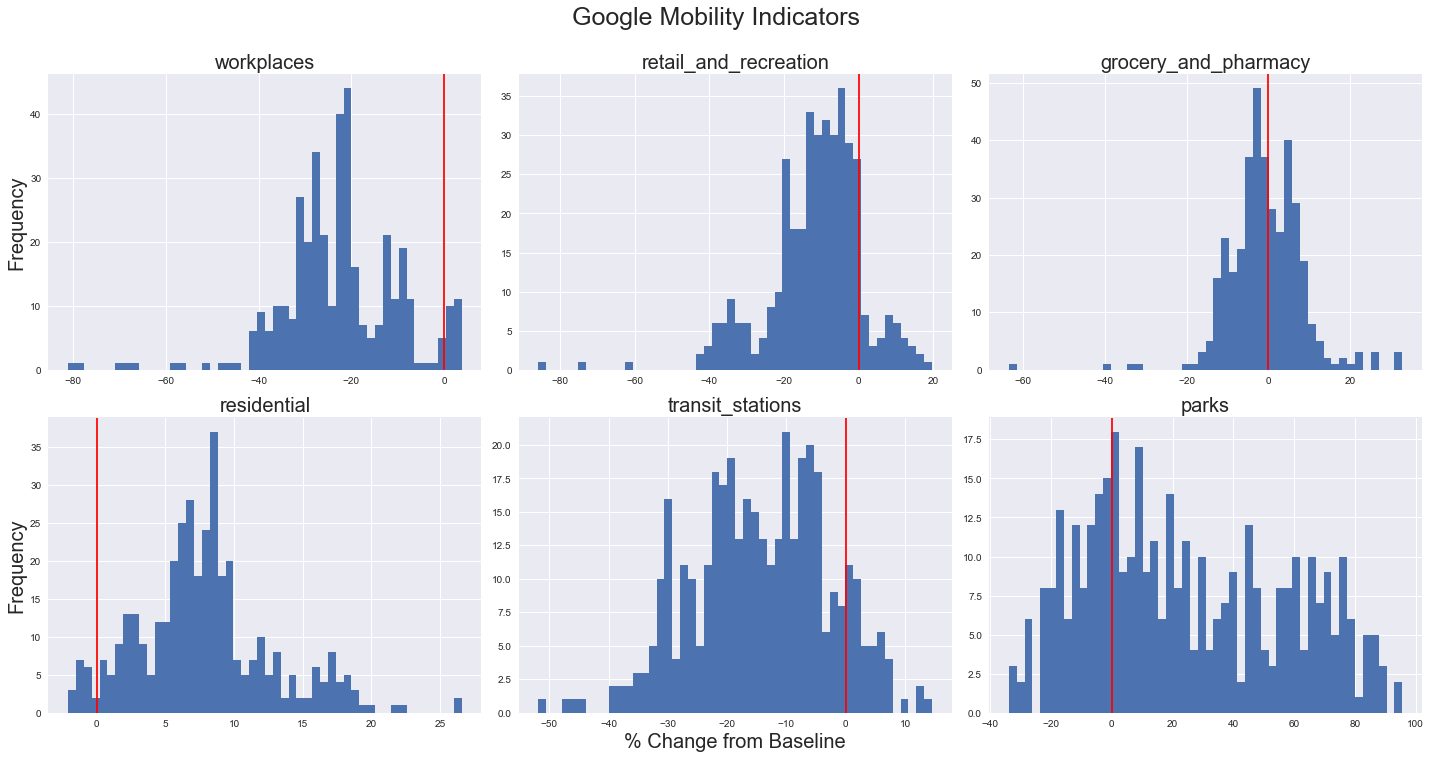

In [16]:
nrows, ncols, nbins = 2, 3, 50

fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df[col_list[count]]
        ax[row][col].hist(series, bins = nbins)
        ax[row][col].set_title(col_list[count], fontsize = label_size)
        ax[row][col].axvline(x=0, color= 'r')
        count+=1
    ax[row][0].set_ylabel('Frequency', fontsize = label_size)   
ax[1][1].set_xlabel('% Change from Baseline', fontsize = label_size)
plt.suptitle('Google Mobility Indicators', y = 1.05, fontsize = label_size+5)
plt.tight_layout()

> *Observations*
>
> By plotting the histogram of mobility, we can see the characteristic distribution of each indicator.
> - Mobility trends around workplaces are predominantly negative indicating lower mobility relaitive to the baseline, and seem to center around minus 20%. There are also scattered values between -80 to -40 percent-change that require further cleaning/investigation for interpretation.
> - Mobility around places of retail, restaurants, and recreation contain many extreme low values which may pose problems in downstream analysis. 
> - Mobility trends around parks and places of residence seem to be mostly positive with two overlapping peaks in parks. 
> - Mobility around markets and drug stores seem to be centered around 0% change (in contrast to all other indicators), however, both ends seems to have scattered extreme values that may require further investigation.

### Look at a Zoomed-In Window

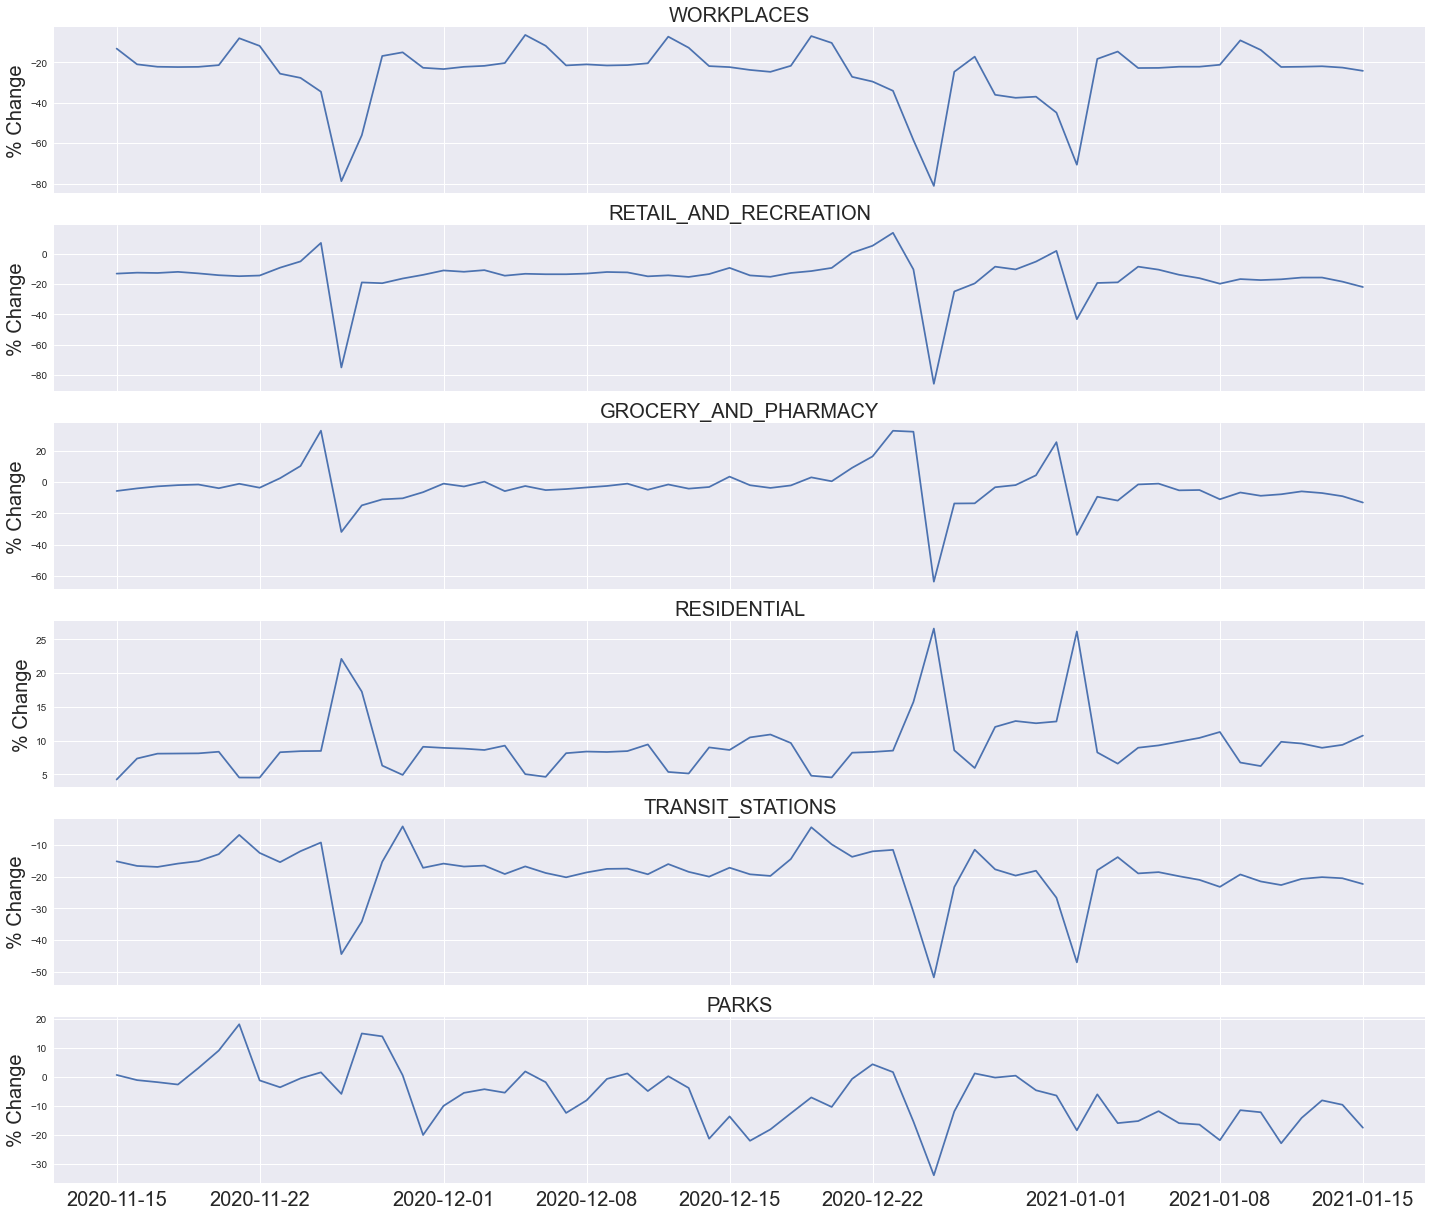

In [17]:
nrows, ncols = 6, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(20,17), squeeze=False, sharex=True)

# Choose range of interest
start = '2020-11-15'
end = '2021-01-15'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        #ax[row][col].axvline(x=0, color= 'r')
        count+=1
    ax[row][0].set_ylabel('% Change', fontsize = label_size)
plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
> 
> When zoomed into the "holiday season", we can see the relationship between the mobility trends more clearly. The peaks in residential data show the private celebrations held by Americans around Thanksgiving, Christmas, and the New Year. These are the %-changes compared to a non-holiday baseline so it is expected that all other indicators would display a downward spiking mobility trend. Distinct cyclic behavior in workplace mobility is evident weekly, and appears to correspond with dips in residential mobility. This could be an indication of data-seasonality which will hinder series stationarity if left untreated.

### Look at the Entire Data

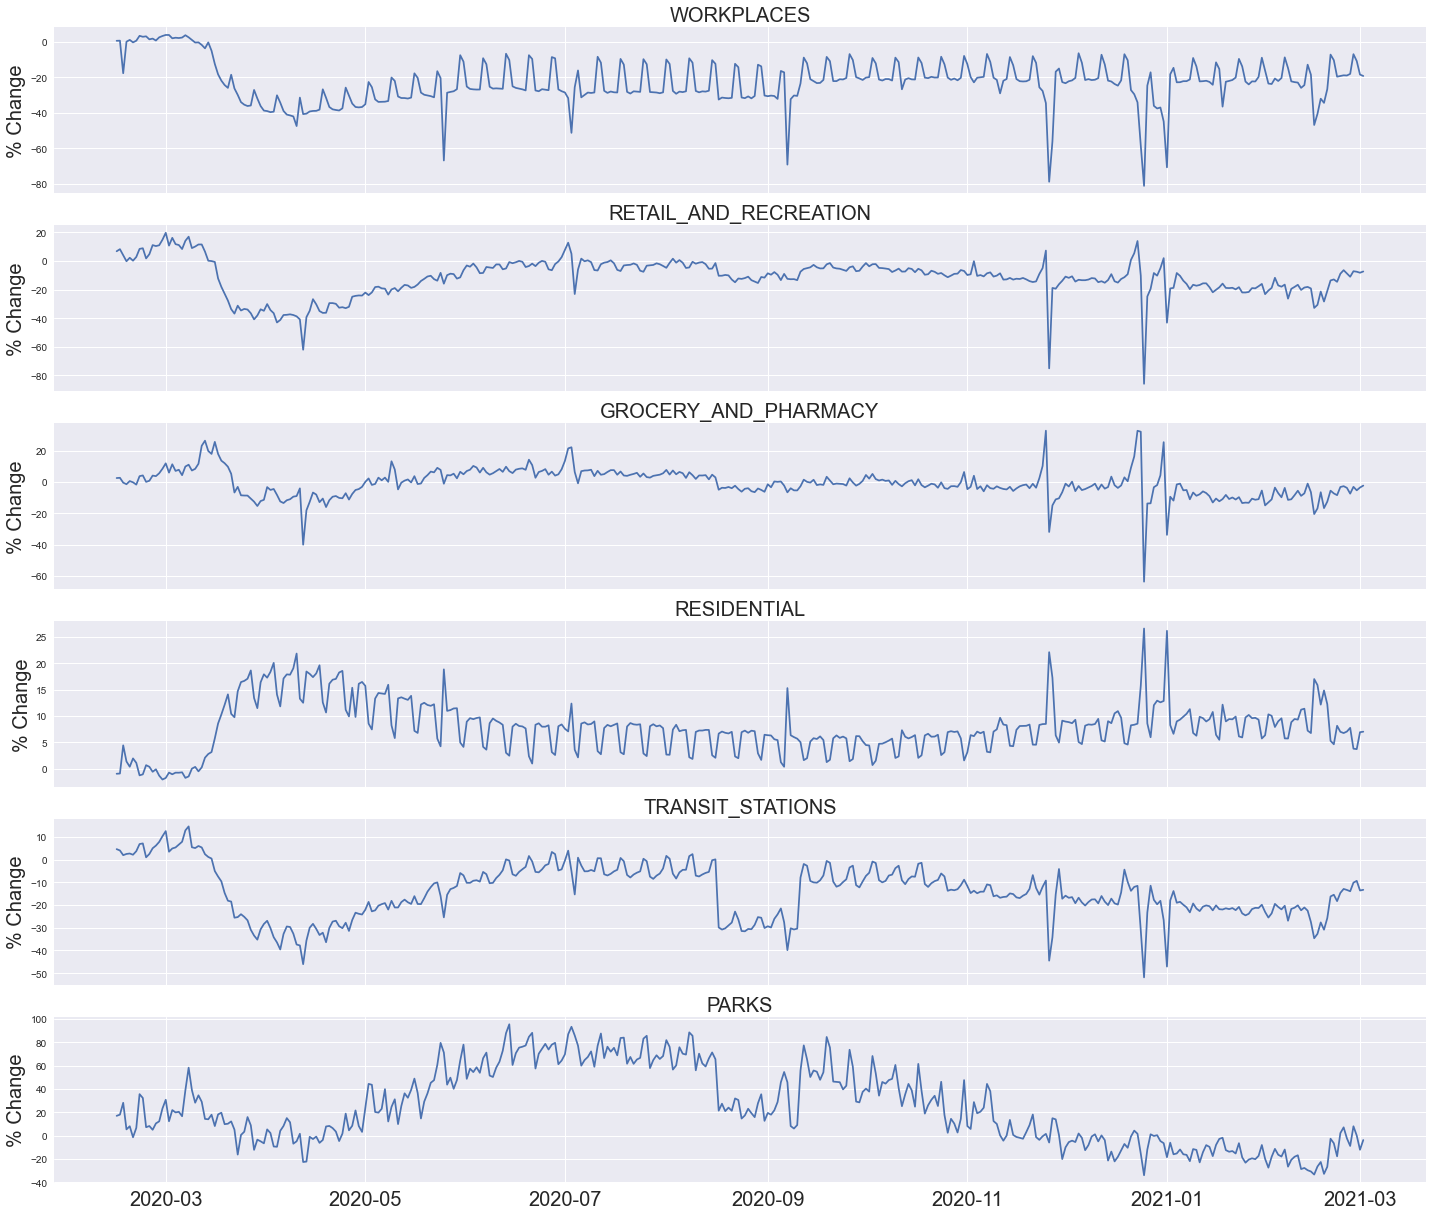

In [18]:
nrows, ncols = 6, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(20,17), squeeze=False, sharex=True)

# Choose range of interest
start = '2020-02-15'
end = '2021-03-02'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        #ax[row][col].axvline(x=0, color= 'r')
        count+=1
    ax[row][0].set_ylabel('% Change', fontsize = label_size)
plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
>
> A full year's worth of daily data is too condensed. Although some significant impacts such as national holidays and government enforced shutdowns can be identified, it's quite difficult to obtain actionable insights from the entire dataset. Big-picture insights can be extracted from subtle variations in the data after further processing.


## Resampling

[[ go back to the top ]](#Table-of-contents)

Resampling is a common technique used to change the frequency of the data while preserving the overall patterns (trend, seasonality). This is a technique often used to upsample and intrapolate data into higher frequency or to downsample to summarize the data. 

Jason Brownlee's blog on [How To Resample and Interpolate Your Time Series Data With Python](https://machinelearningmastery.com/resample-interpolate-time-series-data-python/) provides a more in-depth read about the resampling technique.

In our analysis here, we will downsample to generate more understandable view of our dataset.

In [19]:
def resample_rolling(data = df, d = 7, f = 'W'):
    # Figsize probably needs to be generalized to remove hardcoded dimensions
    fig, axs = plt.subplots(nrows = 2,
                            ncols = 1,
                            sharex= True,
                            sharey=True,
                            figsize=(14,8))
    days = d
    freq = f
    df_0 = data
    
    # Resample
    df_m = df_0.resample(freq).mean()
    # Rolling mean
    df_rm = df_0.rolling(days).mean()
    
    #sns.lineplot(data = df_0, ax = axs[0]);
    sns.lineplot(data = df_m, ax = axs[0], legend = False);
    
    #sns.lineplot(data = df_0, ax = axs[1]);
    sns.lineplot(data= df_rm, ax = axs[1], legend = 'full');
    
    plt.suptitle('Percent Change from "Baseline', fontsize = label_size)
    #axs[0].xticks(fontsize =label_size), plt.yticks(fontsize =label_size)
    #axs[0].get_legend().remove()
    axs[1].legend(fontsize = 13,
                  #loc='best',
                  bbox_to_anchor=(0.5, 0.6, 0.5, 0.1)) # (x, y, width, height)
    plt.tight_layout()
    return

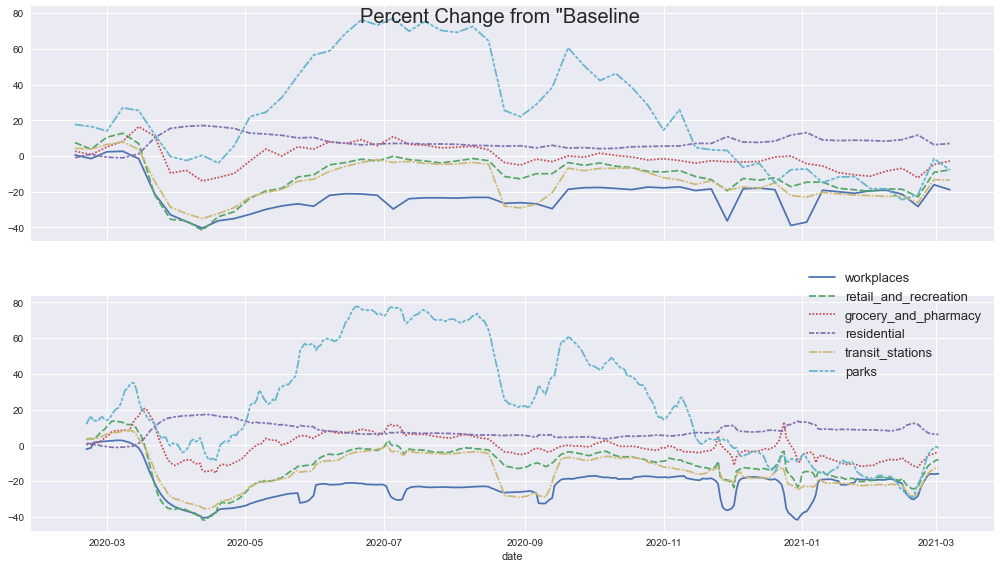

In [20]:
resample_rolling()

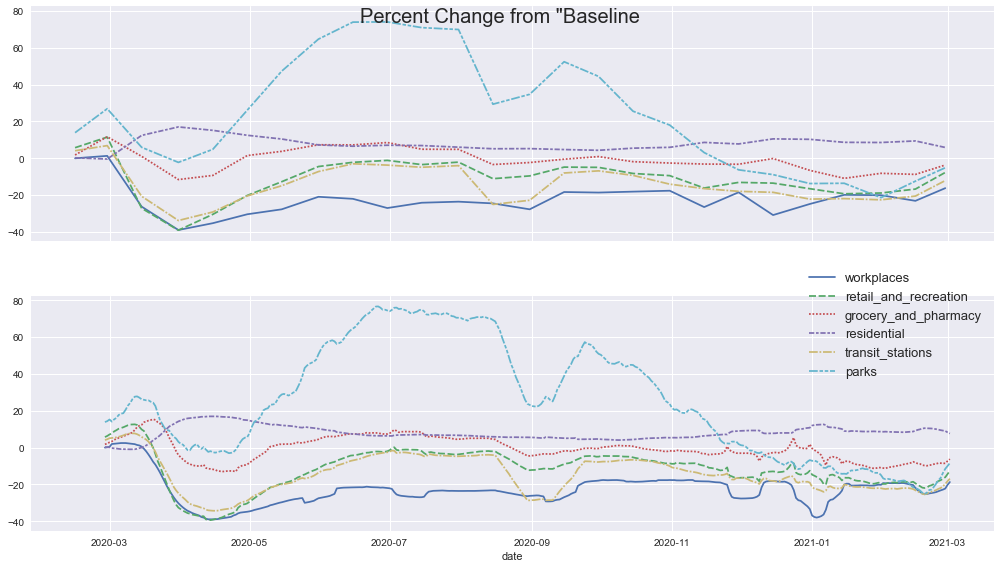

In [21]:
resample_rolling(d=14, f='SM')

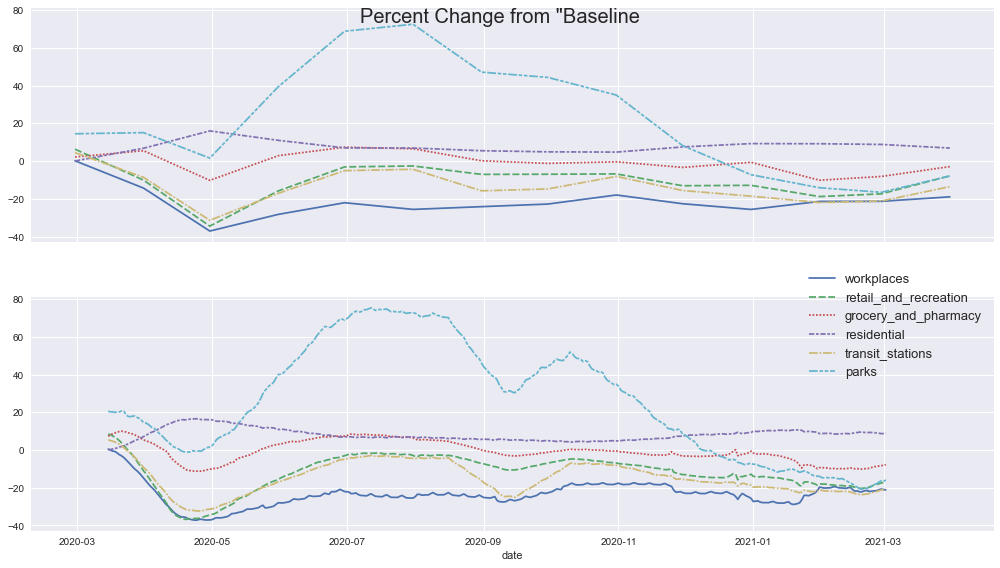

In [22]:
resample_rolling(d=30, f='M');

> *Observations*
>
> We can clearly see a downward trend in parks mobility when the winter months bring less favorable outdoor weather. Currently, it can be seen that all mobility indicators are converging together slightly lower than this time last year except, notably, residential mobility trends remain steadily around 10% higher. This visualization allows us to quickly identify intervals for close inspection, aiding in an abnormality analysis.
>
> **The rest of the analysis, will focus on working with the resampled mobility data**

In [23]:
#resample_rolling(d=90, f='Q')
#resample_rolling(d=180, f='BA')
#resample_rolling(d=365, f='Y')
freq = 'W'
df_r = df.resample(freq).mean()

The data will be subset up until 2020-08-08 where the mobility was relative stable for model building and analysis. The latter part of the data shows sharp spikes that may be result of government shutdowns, holidays, etc. which might not suitable for time-series modeling.

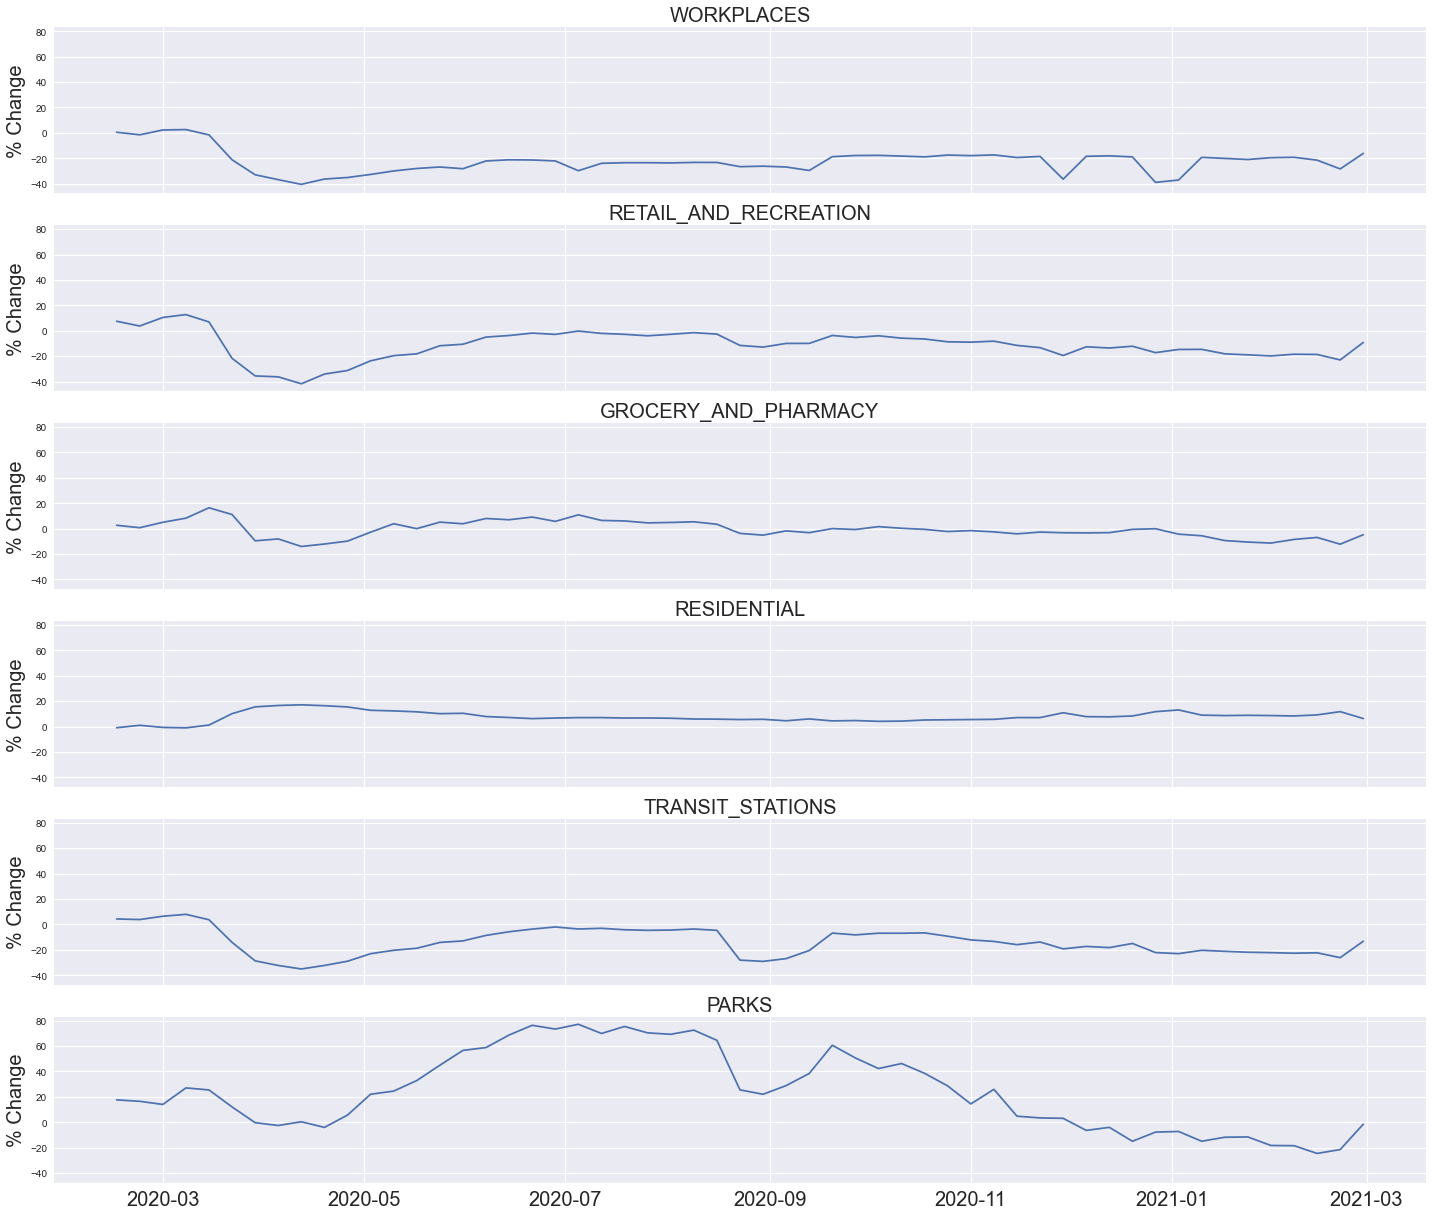

In [24]:
nrows, ncols = 6, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(20,17), squeeze=False, sharey = True, sharex=True)

# Choose time-series subset(date range of interest)
start = '2020-02-15' # '2020-02-15' first date
end = '2021-03-02'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df_r.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('% Change', fontsize = label_size)
plt.xticks(fontsize =label_size)
plt.tight_layout()

## Decomposition

[[ go back to the top ]](#Table-of-contents)

On the most basic level, time-series is comprised of:
- Trend: 
> The general pattern of progress (e.g. The steady decrease of mobility in the workplace )
- Seasonality:
> Cyclic pattern of progress (eg. The decrease of parks mobility in the winter)
- Residual:
> the remaining effects in an observation not contributed by trend or seasonality. This may be noise or other random processes. The residuals is assumed to be stationary (not dependent on time), and is an important aspect to time series modelling and forecasting

A time series may also be additive or multiplicative. 
- Additive: $n_{t} = trend + seasonality + residual$
- Multiplicative: $n_{t} = trend * seasonality * residual$

The most obvious difference between an additive and multiplicative model is the increase of variance overtime in multiplicative models. Whereas the variance in additive model is relatively constant. 

The left is an example of *additive* time series and the right is an example of *multiplicative* time series. Image from [Data Camp](https://campus.datacamp.com/courses/arima-models-in-python/chapter-4-seasonal-arima-models?ex=12).

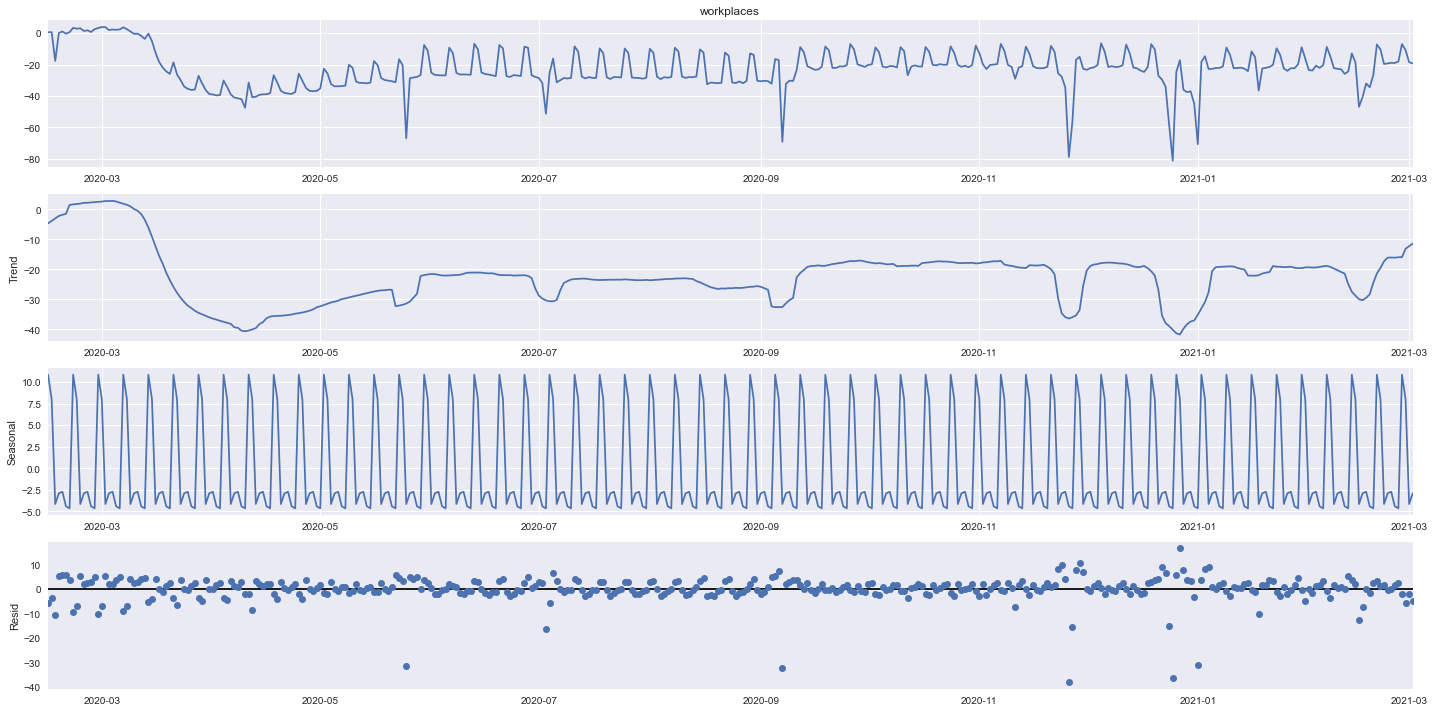

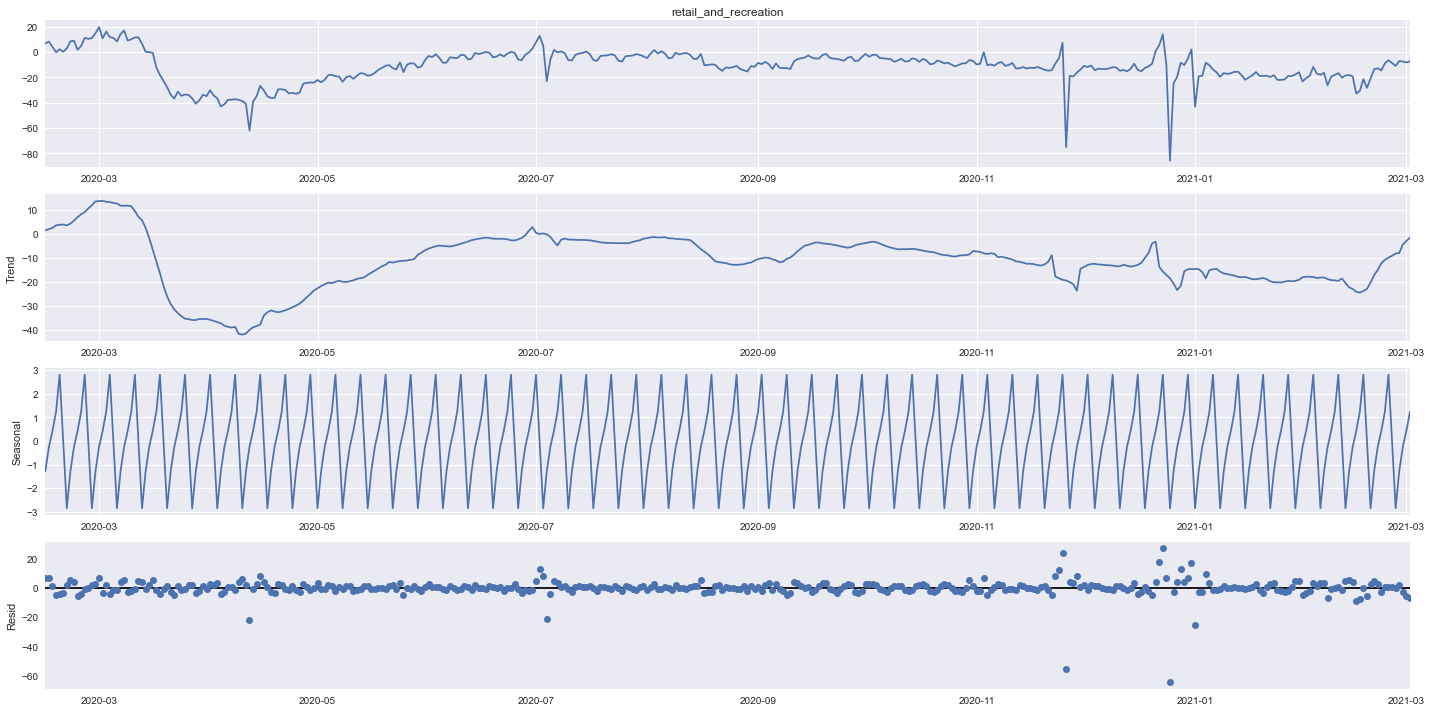

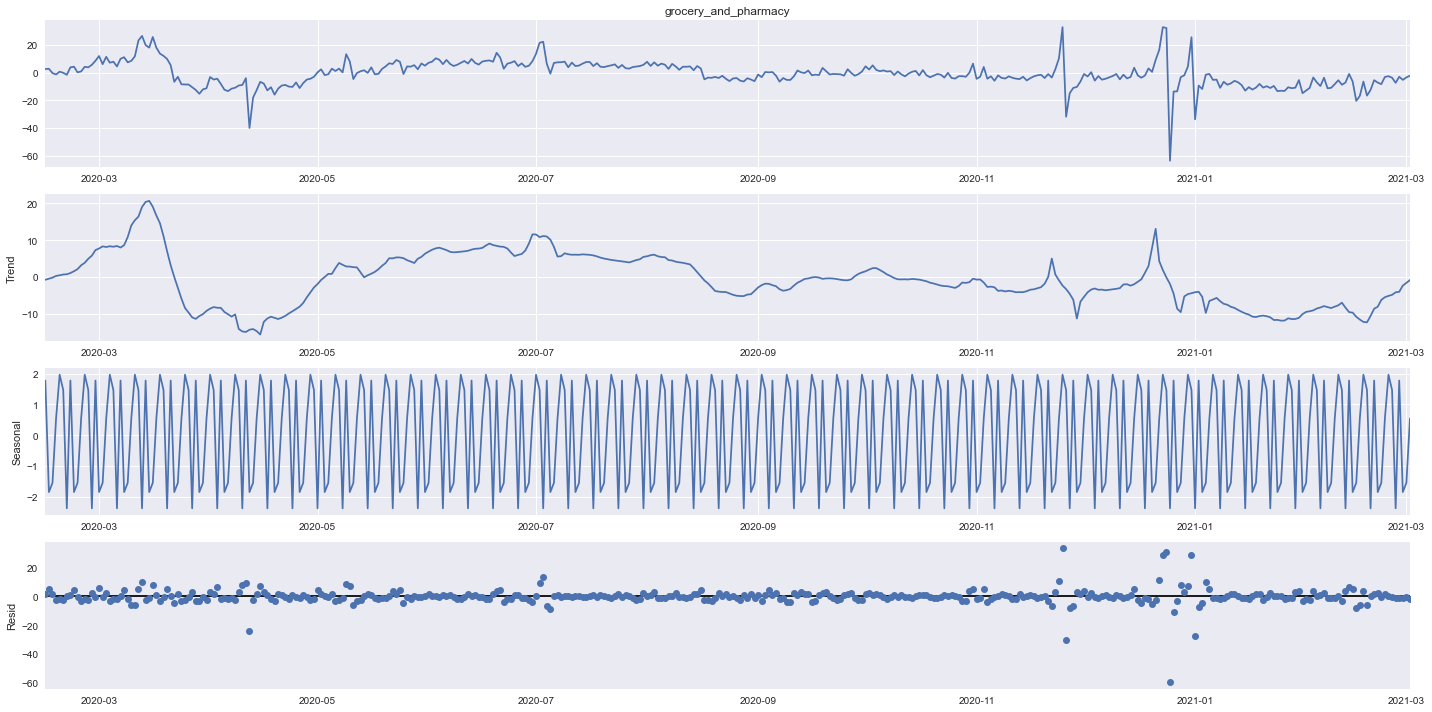

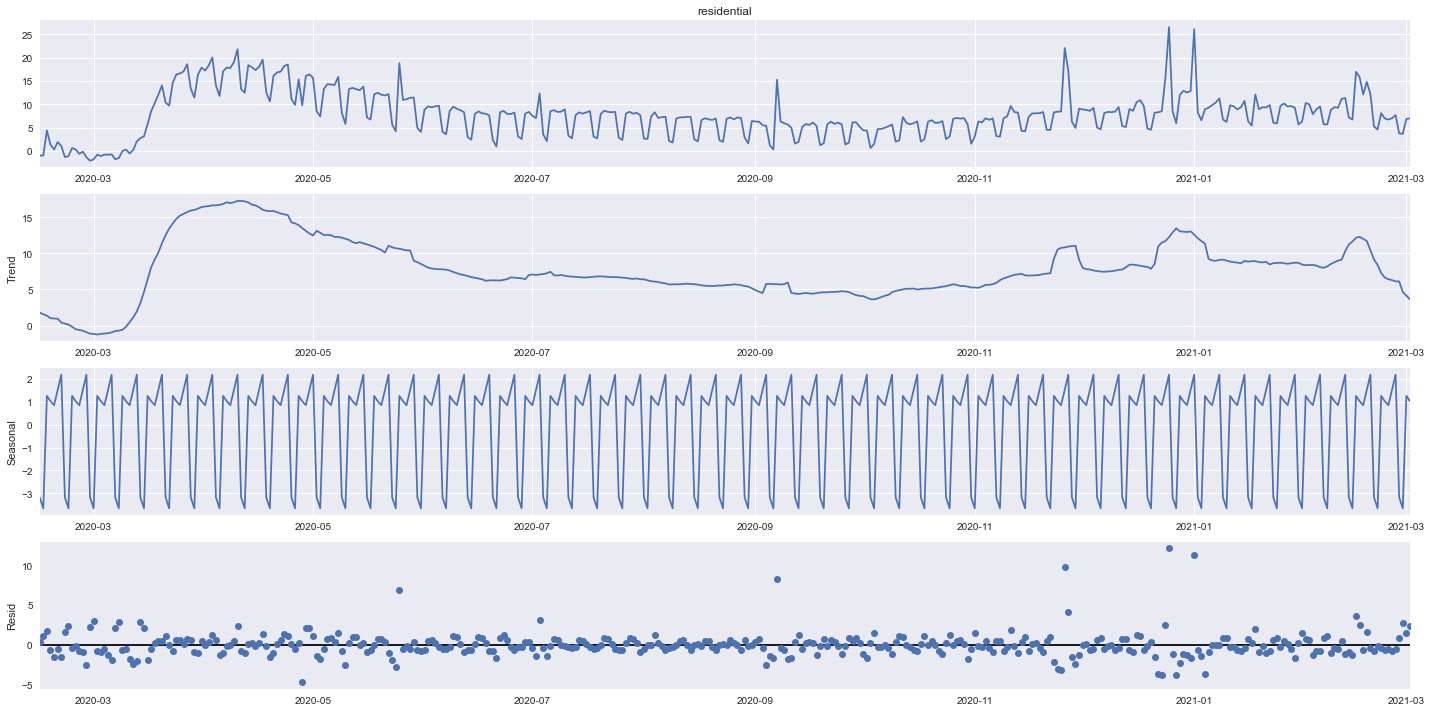

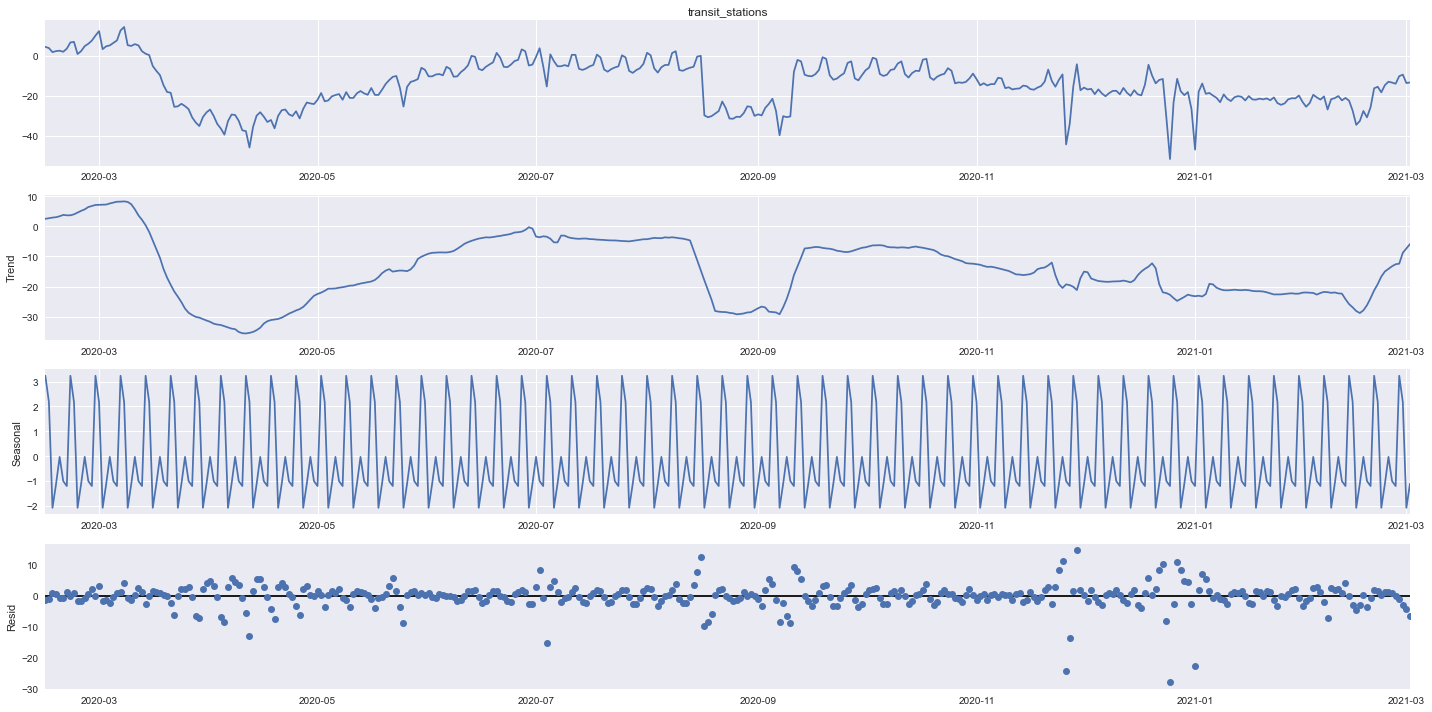

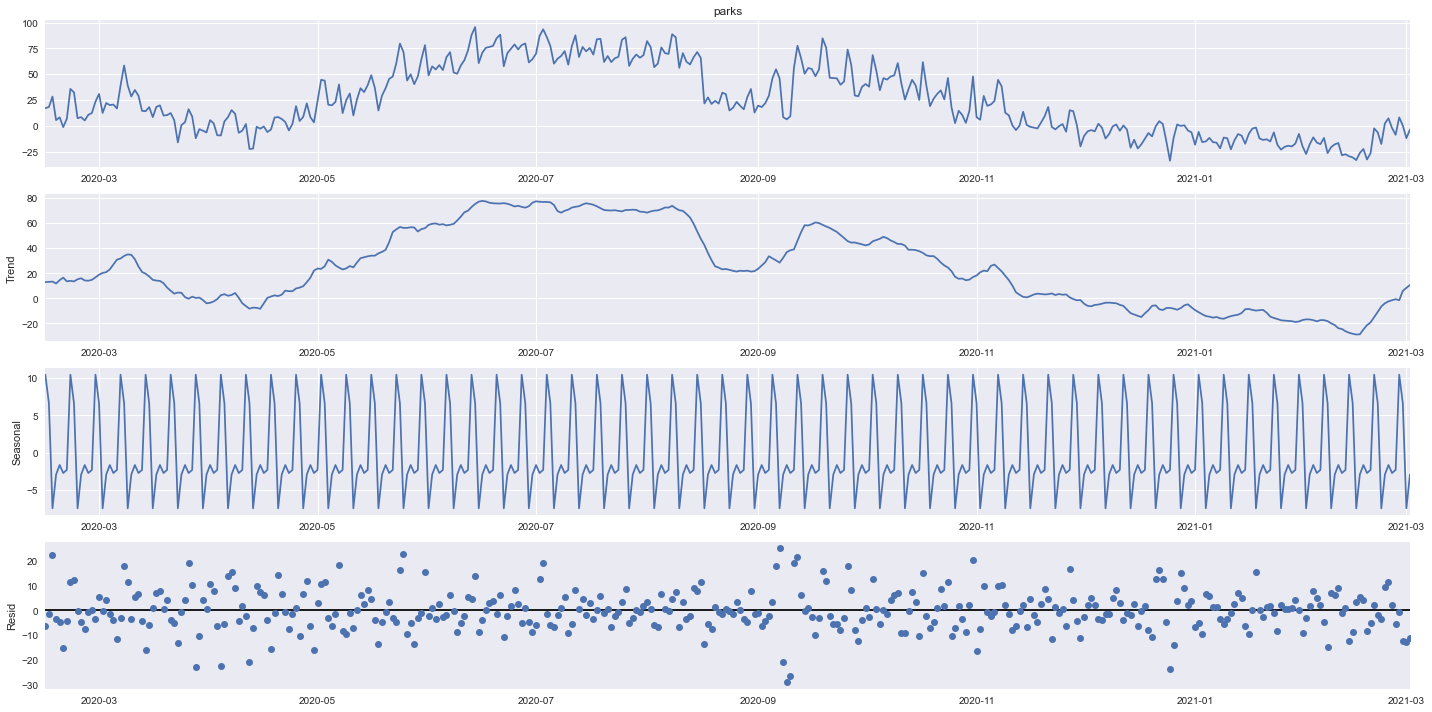

In [25]:
# Decompose time-series into Trend, Seasonality and Residuals
for col in range(len(list(df.columns))):
    decomposed = sm.tsa.seasonal_decompose(df[col_list[col]], model = 'additive', extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()
    
    # Three components
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    residual = decomposed.resid

> *Observations*
>
> With the data decomposed, mobility trends are noticeably short lived. A consistent downward trend is evident, for all indicators other than the increasing-residential and the steady-workplace indicators, from October 2020 through January 2021 (most recent 4 months). The seasonal aspect of the data may or may not be statistically significant, but a more conservative approach handling suggested seasonality may be apropriate.

## Time Series Stationarity


[[ go back to the top ]](#Table-of-contents)


The first step to build an ARIMA model is to make the time series **stationary**.

__Check if the time series is stationarity or not:__

1. __Rolling Statistics__: Plot the moving average & moving variance, check if it varies with time.
  - Moving average/variance: For any moment in time, the average/variance of the last x-days.

  
2. __Augmented Dickey-Fuller Test:__ One statistical test for checking stationarity.
  - Null Hypothesis (H0): Time-series is not stationary. <br>
  - Alternate Hypothesis (H1): Null hypothesis is rejected, time-series is stationary.
> p-value >  Threshold: Data is non-stationary, fail to reject H0. <br>
> p-value <= Threshold: Data is stationary, reject H0.

NOTE: Most commonly: Threshold = 0.05

Reference: https://otexts.com/fpp2/stationarity.html

In [37]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()

    #Plot rolling statistics:
    plt.figure(figsize = (20,5))
    orig = plt.plot(timeseries, color='blue',label= f'Actual Series: {col_list[col]}')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print (f'Results of Dickey-Fuller Test: {col_list[col]}')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print()

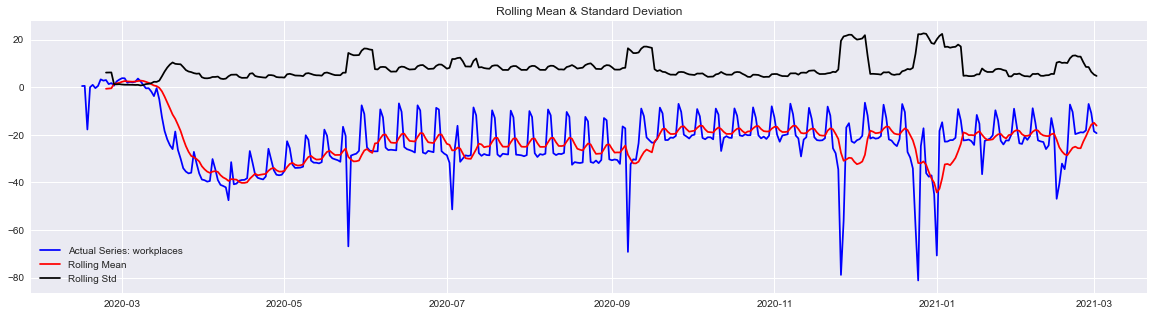

Results of Dickey-Fuller Test: workplaces
Test Statistic                  -3.707978
p-value                          0.004002
#Lags Used                      14.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64



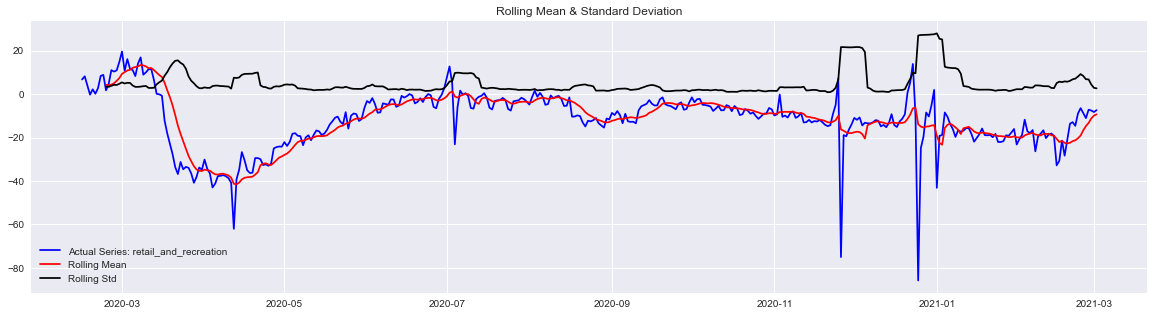

Results of Dickey-Fuller Test: retail_and_recreation
Test Statistic                  -2.590090
p-value                          0.095063
#Lags Used                       9.000000
Number of Observations Used    372.000000
Critical Value (1%)             -3.448052
Critical Value (5%)             -2.869341
Critical Value (10%)            -2.570926
dtype: float64



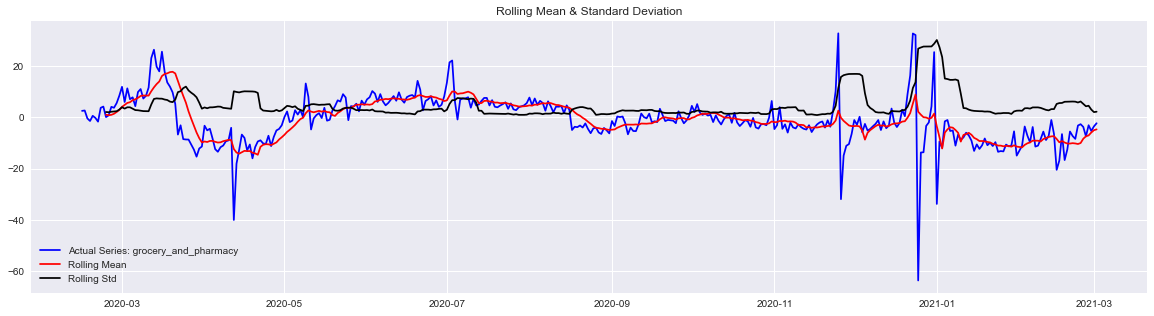

Results of Dickey-Fuller Test: grocery_and_pharmacy
Test Statistic                  -2.561505
p-value                          0.101217
#Lags Used                       6.000000
Number of Observations Used    375.000000
Critical Value (1%)             -3.447909
Critical Value (5%)             -2.869278
Critical Value (10%)            -2.570892
dtype: float64



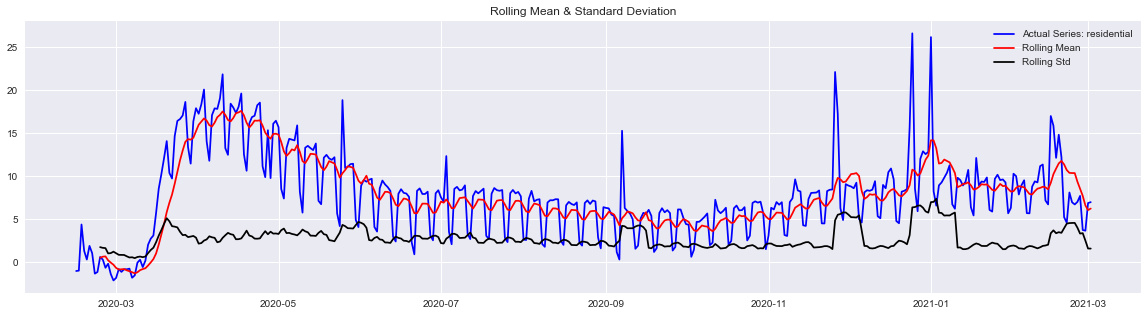

Results of Dickey-Fuller Test: residential
Test Statistic                  -3.059535
p-value                          0.029696
#Lags Used                      14.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64



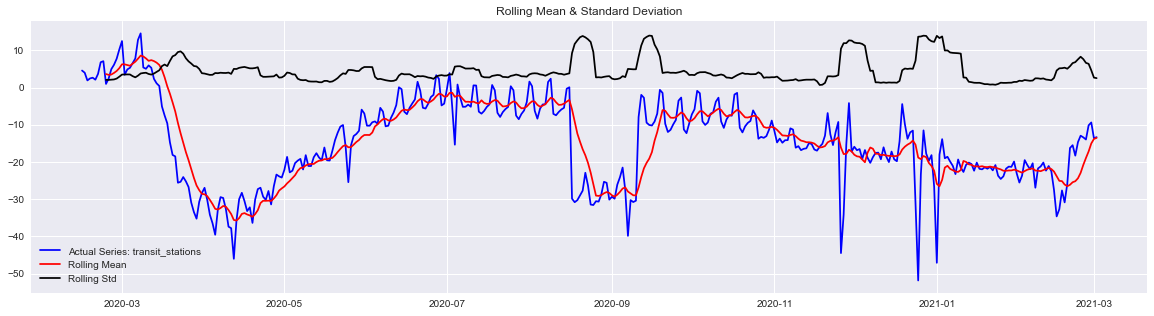

Results of Dickey-Fuller Test: transit_stations
Test Statistic                  -2.745256
p-value                          0.066529
#Lags Used                       7.000000
Number of Observations Used    374.000000
Critical Value (1%)             -3.447956
Critical Value (5%)             -2.869299
Critical Value (10%)            -2.570903
dtype: float64



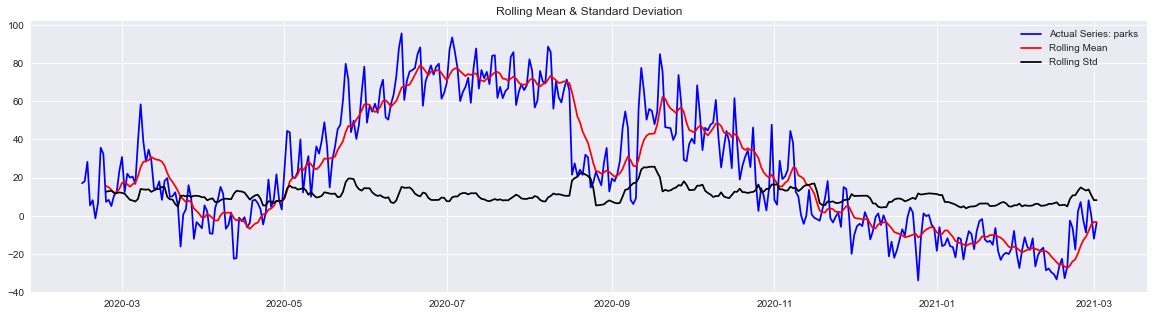

Results of Dickey-Fuller Test: parks
Test Statistic                  -1.454438
p-value                          0.555918
#Lags Used                      14.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64



In [38]:
for col in range(len(list(df.columns))):
    test_stationarity(df[col_list[col]])

> **Insights**
>
> Without further processing, the trends in retail, grocery, transit, and parks mobilities are not stationary. This is identified by the observable trends in rolling 10-day means(red) and acceptance of the "Dickey-Fuller H0's" that the mobility indicators are not stationary(p-value > 0.05). In particular, H0 is rejected for mobility trends around workplaces and places of residence (p-value < 0.05).

### Differencing

[[ go back to the top ]](#Table-of-contents)

In [47]:
# Create a differenced series
def difference(dataset, interval=1):
    difference = dataset-dataset.shift(interval)
        
    return difference.dropna(inplace= False)

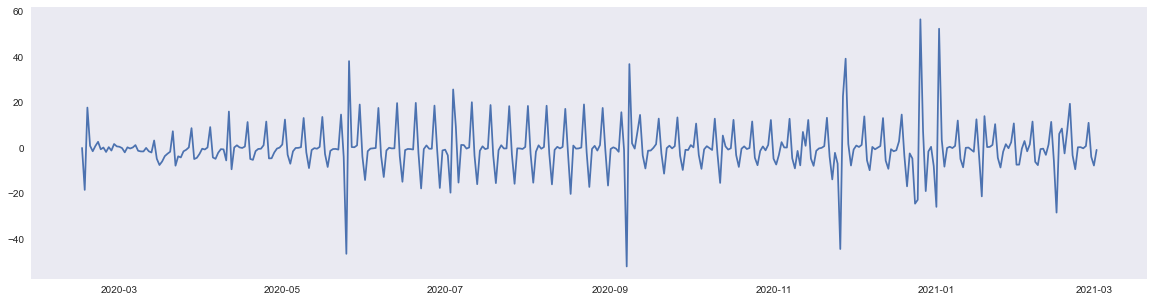

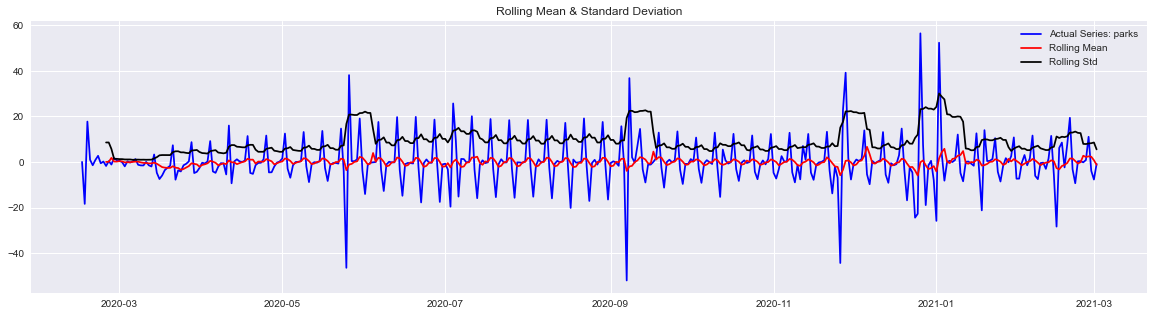

Results of Dickey-Fuller Test: parks
Test Statistic                -6.187794e+00
p-value                        6.227997e-08
#Lags Used                     1.300000e+01
Number of Observations Used    3.670000e+02
Critical Value (1%)           -3.448294e+00
Critical Value (5%)           -2.869448e+00
Critical Value (10%)          -2.570983e+00
dtype: float64



In [51]:
df_differenced = difference(df[['workplaces']])
plt.figure(figsize=(20,5))
plt.plot(df_differenced)
plt.grid()
test_stationarity(df_differenced)

## Autocorrelations and Partial Autocorrelations

[[ go back to the top ]](#Table-of-contents)

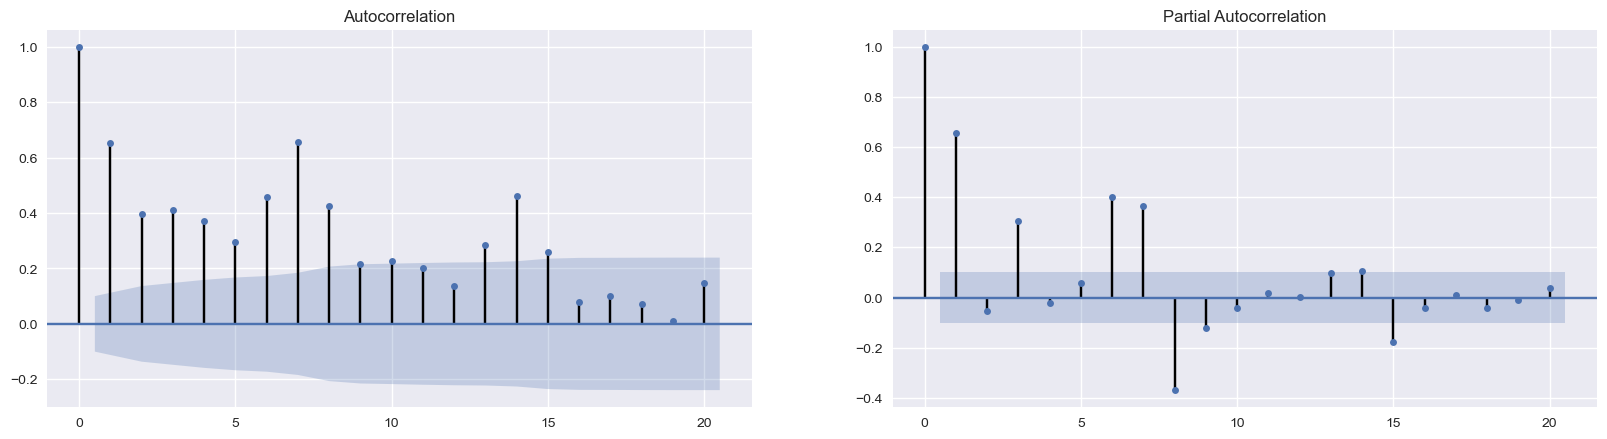

In [42]:
## Calculate the ACF and PACF for the flow series up to 20 lags
# acf_20 = acf(ts_sub, nlags=20)
# pacf_20 = pacf(ts_sub, nlags=20)
timeseries = df['workplaces']
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,5), dpi= 100)
plot_acf(timeseries, lags=20, ax=axes[0])
plot_pacf(timeseries, lags=20, ax=axes[1])
plt.show()

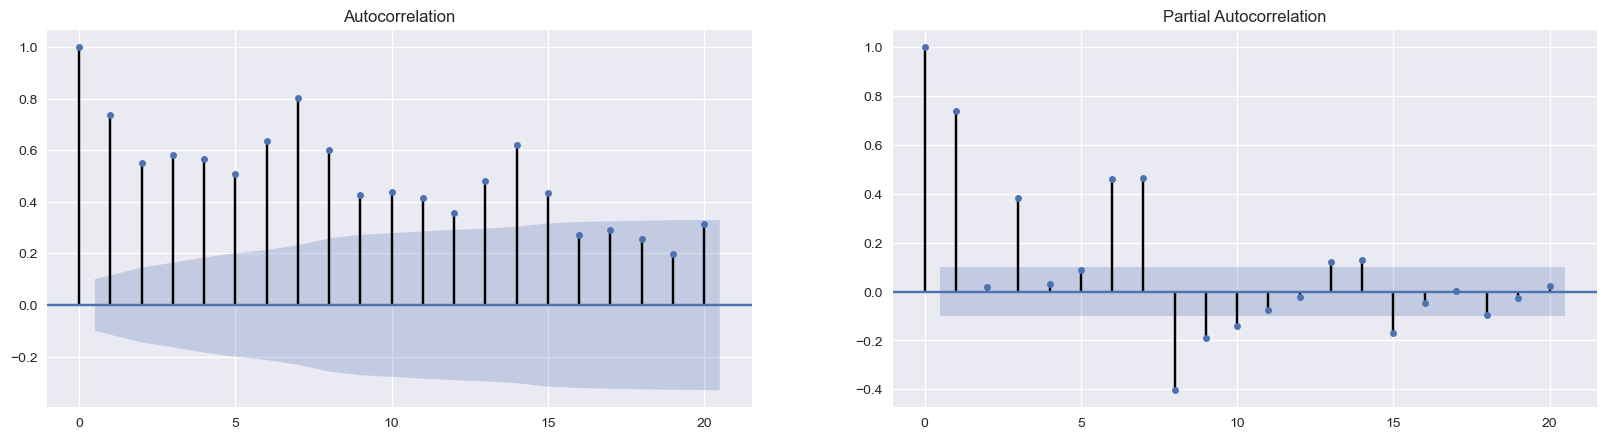

In [43]:
## Calculate the ACF and PACF for the flow series up to 20 lags
# acf_20 = acf(ts_sub, nlags=20)
# pacf_20 = pacf(ts_sub, nlags=20)
timeseries = df['residential']
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,5), dpi= 100)
plot_acf(timeseries, lags=20, ax=axes[0])
plot_pacf(timeseries, lags=20, ax=axes[1])
plt.show()

## ARIMA Modelling

[[ go back to the top ]](#Table-of-contents)

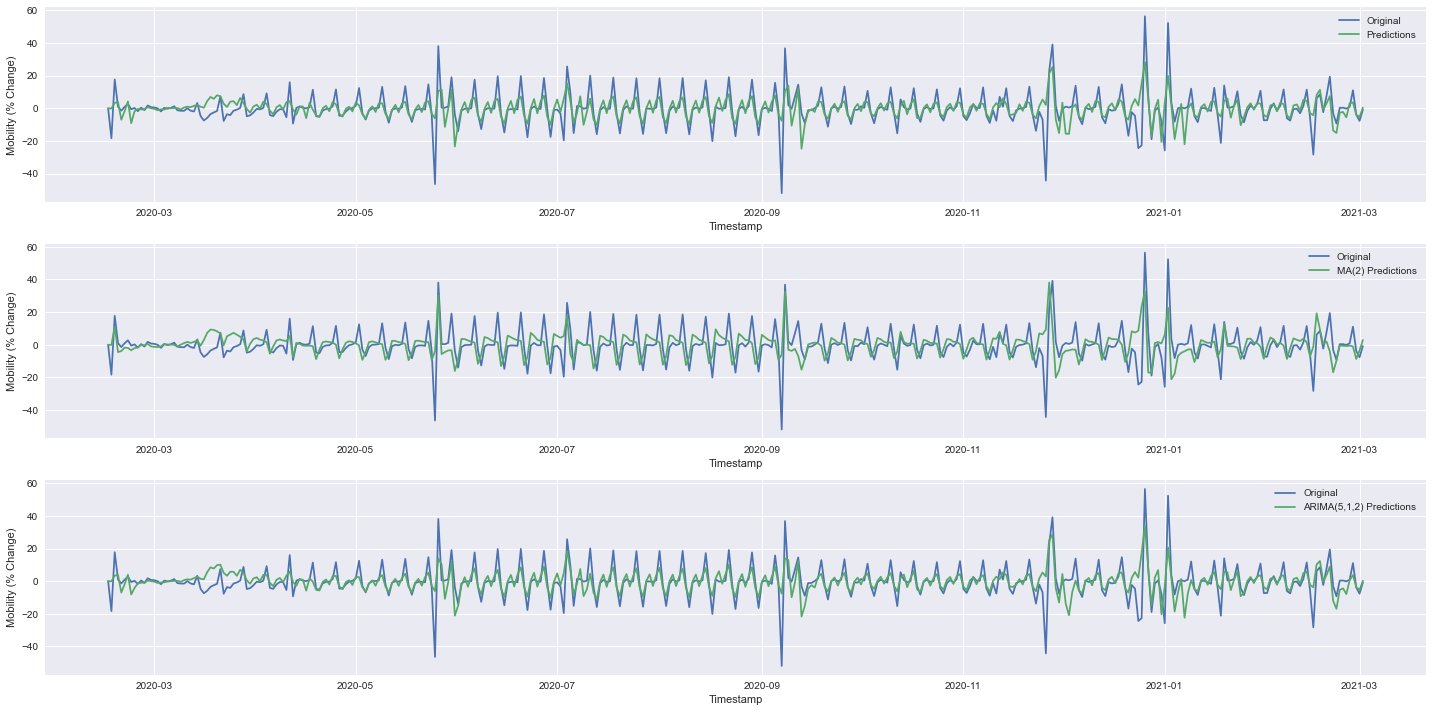

In [56]:
fig, ax = plt.subplots(3,1,figsize=(20,10))

df_sub = df[['workplaces']]

# AR Model (p = 5)
model = ARIMA(df_sub, order=(5,1,0))
results_AR = model.fit(disp=-1)

ax[0].plot(df_differenced, label = 'Original')
ax[0].plot(results_AR.fittedvalues, label = 'Predictions')
#ax[0].set_title('AR(5) Model - RSS: %.4f'%sum((results_AR.fittedvalues - df_differenced)**2))
ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel('Mobility (% Change)')
ax[0].legend()

# MA Model (q = 1)
model = ARIMA(df_sub, order=(0,1,1))
results_MA = model.fit(disp=-1)

ax[1].plot(df_differenced, label = 'Original')
ax[1].plot(results_MA.fittedvalues, label='MA(2) Predictions')
#ax[1].set_title('MA(2) Model - RSS: %.4f'%sum((results_MA.fittedvalues - df_differenced)**2))
ax[1].legend()
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('Mobility (% Change)')

# ARIMA model (p = 5, d = 1, q = 1)
model = ARIMA(df_sub, order=(5,1,1))
results_ARIMA = model.fit(disp=-1)

ax[2].plot(df_differenced, label = 'Original')
ax[2].plot(results_ARIMA.fittedvalues, label = 'ARIMA(5,1,2) Predictions')
#ax[2].set_title('ARIMA(5,1,1) Model - RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_differenced)**2))
ax[2].legend()
ax[2].set_xlabel('Timestamp')
ax[2].set_ylabel('Mobility (% Change)')


# plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - ts_differenced)**2))
# plt.xlabel('Timestamps')
# plt.ylabel('Flow (E3M3)')
# plt.legend()
plt.tight_layout()

In [ ]:
# Decompose the time-series into Trend, Seasonality and Residuals
for col in range(len(list(df.columns))):
    decomposed = sm.tsa.seasonal_decompose(df[col_list[col]], model = 'additive', extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()

In [57]:
df

,workplaces,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks
date,,,,,,
2020-02-15,0.502403,6.767918,2.568272,-0.988119,4.553895,17.078580
2020-02-16,0.567077,8.225749,2.717209,-0.944541,3.967670,18.122368
2020-02-17,-17.756044,4.049697,-0.375113,4.405907,1.903259,28.271605
2020-02-18,-0.006305,-0.211659,-1.377153,1.345745,2.440042,5.466077
2020-02-19,1.001656,2.222899,0.639556,0.345455,2.634615,8.153166
...,...,...,...,...,...,...
2021-02-26,-18.122059,-11.026122,-7.390536,7.725445,-13.963636,-8.750973
2021-02-27,-7.028979,-7.173964,-3.032665,3.771024,-10.169615,8.134422
2021-02-28,-10.865575,-7.526728,-5.262815,3.687106,-9.389011,0.226268
